## Importing the required libraries

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, LeakyReLU
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import time
import codecs
import itertools
import pickle

from keras import regularizers

import os
import librosa
import matplotlib.pyplot as plt
import pandas as pd
import glob
import librosa.display
import scipy.io.wavfile
import numpy as np
import sys

In [ ]:
main_path="/content/drive/MyDrive/NLP_Project/All_audios"
mylist = os.listdir(main_path)
# for i in mylist:
#   if(i.count("_") == 4):
#     os.system("rm " + main_path + "/" + i)

def read_file(filename):
	# Importing sentiment_train file
	training = ""
	try:
		fp = codecs.open(filename, 'r', encoding = 'utf-8', errors = 'ignore')
		training = fp.read()
	except:
		print("File not found")
		text = "File not found"
		exit()
	return training

mapping = read_file("/content/drive/MyDrive/NLP_Project/VideoDemographics.csv")
mapping = mapping.split("\n")

male = {}
female = {}
for i in range(len(mapping)):
	mapping[i] = mapping[i][:-1]
	mapping[i] = mapping[i].split(",")

	if(len(mapping[i])>1 and mapping[i][1] == "Male"):
		male[mapping[i][0]] = 0
	elif(len(mapping[i])>1):
		female[mapping[i][0]] = 0


print(mylist)
print(len(mylist))


['03-01-04-02-02-02-08.wav', '03-01-05-02-01-02-08.wav', '03-01-04-02-01-02-08.wav', '03-01-04-01-02-02-08.wav', '03-01-05-02-01-01-08.wav', '03-01-04-01-02-01-08.wav', '03-01-04-01-01-01-08.wav', '03-01-05-01-01-01-08.wav', '03-01-05-01-02-01-08.wav', '03-01-05-02-02-01-08.wav', '03-01-03-02-02-01-08.wav', '03-01-03-02-02-02-08.wav', '03-01-04-02-01-01-08.wav', '03-01-04-02-02-01-08.wav', '03-01-06-02-01-01-08.wav', '03-01-07-01-01-01-08.wav', '03-01-05-02-02-02-08.wav', '03-01-06-01-02-02-08.wav', '03-01-07-01-02-01-08.wav', '03-01-07-01-02-02-08.wav', '03-01-06-01-01-01-08.wav', '03-01-06-02-02-02-08.wav', '03-01-07-02-01-02-08.wav', '03-01-07-02-01-01-08.wav', '03-01-06-01-01-02-08.wav', '03-01-07-02-02-01-08.wav', '03-01-07-02-02-02-08.wav', '03-01-07-01-01-02-08.wav', '03-01-06-01-02-01-08.wav', '03-01-06-02-02-01-08.wav', '03-01-06-02-01-02-08.wav', '03-01-02-01-02-01-09.wav', '03-01-02-01-02-02-09.wav', '03-01-08-01-01-01-08.wav', '03-01-08-01-02-02-08.wav', '03-01-01-01-01-01-

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
print(mylist[50])

03-01-02-01-01-02-09.wav


In [ ]:
print(mylist[400][6:-16])

02


## Plotting the audio file's waveform and its spectrogram

In [ ]:
data, sampling_rate = librosa.load(main_path+'/'+"1001_IEO_HAP_HI.wav")

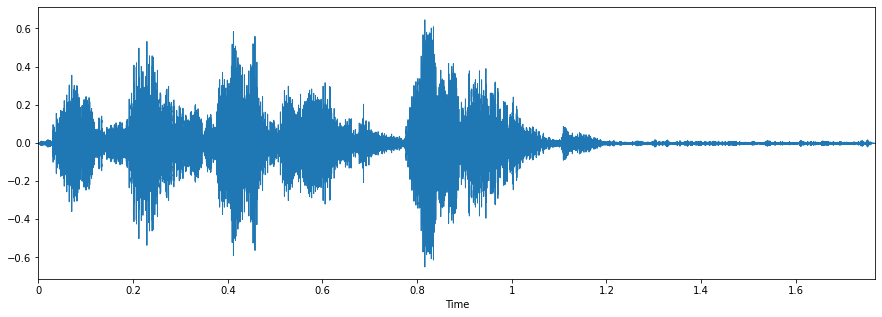

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

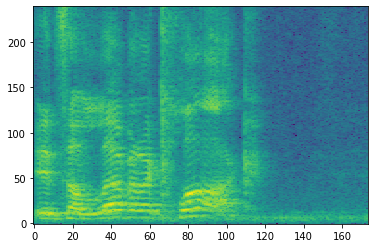

In [ ]:
sr,x = scipy.io.wavfile.read(main_path+'/'+"1001_IEO_HAP_HI.wav")

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros((len(nn), nfft//2))

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',origin='lower',aspect='auto')
plt.show()

## Setting the labels

In [ ]:
feeling_list=[]
map = {('02',0):'female_calm',('02',1):'male_calm',('03',0):'female_happy',('03',1):'male_happy',('04',0):'female_sad',('04',1):'male_sad',
       ('05',0):'female_angry',('05',1):'male_angry',('06',0):'female_fearful',('06',1):'male_fearful',
        'a':'male_angry','f':'male_fearful','h':'male_happy','sa':'male_sad'}

dataset_used = []
for item in mylist:
    if len(item)==24 and (item[6:-16],int(item[18:-4])%2) in map:
      dataset_used.append(item)
      feeling_list.append(map[(item[6:-16],int(item[18:-4])%2)])
    elif item[:1] in map:
      dataset_used.append(item)
      feeling_list.append(map[item[:1]])
    elif item[:2] in map:
      dataset_used.append(item)
      feeling_list.append(map[item[:2]])
    elif(item.count("_") == 3):
      actor = item[:4]
      gen = "male"
      if(female.get(actor) != None):
        gen = "female"

      emotion = ""

      if(item.find("HAP")!=-1 and item.find("HI")!=-1):
        emotion = "happy"
      elif(item.find("SAD")!=-1 and item.find("HI")!=-1):
        emotion = "sad"
      elif(item.find("ANG")!=-1 and item.find("HI")!=-1):
        emotion = "angry"
      elif(item.find("FEA")!=-1 and item.find("HI")!=-1):
        emotion = "fearful"
      if(emotion != ""):
        dataset_used.append(item)
        feeling_list.append(gen + "_" + emotion)

      
print(len(feeling_list))
print(len(dataset_used))

1384
1384


In [ ]:
labels = pd.DataFrame({'label': feeling_list})

In [ ]:
print(len(labels))
labels[:10]

1384


,label
0,female_sad
1,female_angry
2,female_sad
3,female_sad
4,female_angry
5,female_sad
6,female_sad
7,female_angry
8,female_angry
9,female_angry


## Getting the features of audio files using librosa

In [ ]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
c = 0
start_time = time.time()
for index,y in enumerate(dataset_used):
  X, sample_rate = librosa.load(main_path+'/'+y, res_type='kaiser_best',duration=2.5,sr=22050*2,offset=0.5)
  sample_rate = np.array(sample_rate)

  mfcc_feature = librosa.feature.mfcc(y=X, sr=sample_rate,dct_type=2,norm='ortho', n_mfcc=15)
  mfccs = np.mean(mfcc_feature,axis=0)

# //SHAYAD [0]th index ka element nikalna hai inn features se bhi
  mel_spec= librosa.feature.melspectrogram(y=X, sr=sample_rate)[0]
  # print(mel_spec)
  chromagram = librosa.feature.chroma_stft(y=X, sr=sample_rate)[0]
  # print(chromagram)
  spectral_rolloff = librosa.feature.spectral_rolloff(y=X, sr=sr)[0]
  # print(spectral_rolloff)
                                      
  zero_cross = librosa.feature.zero_crossing_rate(y=X,center=True)
  zero_cross_s = zero_cross[0]
  stft = librosa.stft(X)
  energy = librosa.feature.rmse(S= stft)
  energys = energy[0]

  spectral_centroid = librosa.feature.spectral_centroid(y=X,sr=sampling_rate)
  spectral_centroids = spectral_centroid[0]

  #mfccs,zero_cross_s,energys,spectral_centroids,mel_spec,chromagram,spectral_rolloff

  feature = list(itertools.chain(mfccs,energys))
  # print(len(feature))
  df.loc[bookmark] = [feature]
  # print(bookmark)
  bookmark=bookmark+1  

          
end_time = time.time()
print("Time taken: ", end_time - start_time) 



Time taken:  421.95144963264465


In [ ]:
# Loading saved features

# df = pd.read_pickle("/content/drive/MyDrive/NLP_Project/dfsave_mfcss_energy_mel_spec.pkl")

In [ ]:
print(len(df))
df[:5]


1384


,feature
0,"[-41.91602878353221, -42.72025114196795, -44.1..."
1,"[-35.55860223841591, -34.40006374327899, -34.0..."
2,"[-39.303441468463596, -40.90503136053329, -43...."
3,"[-49.52277879925482, -47.50182410208053, -44.4..."
4,"[-41.35155706755196, -41.24156350641981, -41.3..."


In [ ]:
df3 = pd.DataFrame(df['feature'].values.tolist())
# print(len(df))
# print(len(df3))
df3[:5]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431
0,-41.916029,-42.720251,-44.134782,-43.356630,-41.519287,-41.382523,-42.971226,-41.494845,-40.112007,-42.490165,-41.222184,-39.994388,-41.296296,-41.149056,-40.985169,-41.307526,-42.311792,-44.254157,-46.624736,-43.631549,-44.533047,-46.108207,-45.807512,-48.282699,-47.929808,-46.244256,-44.942508,-44.268176,-46.066034,-47.343536,-47.254934,-46.456347,-46.447616,-47.782634,-45.359170,-46.220059,-46.803634,-45.696713,-46.879944,-45.520421,...,0.148373,0.162066,0.177228,0.144181,0.073324,0.049502,0.035058,0.021362,0.018331,0.011810,0.009538,0.007510,0.005572,0.005693,0.007534,0.004985,0.003421,0.003699,0.003599,0.002359,0.002229,0.001723,0.001748,0.002121,0.002699,0.003229,0.003231,0.003835,0.004359,0.004991,0.004904,0.006751,0.007383,0.007735,0.007301,0.006184,0.006123,0.005675,0.005895,0.006238
1,-35.558602,-34.400064,-34.072053,-35.258230,-35.881312,-35.207021,-34.477047,-35.009424,-34.005166,-34.162143,-34.542952,-34.150494,-34.184923,-34.548425,-33.677869,-34.070109,-33.511885,-34.760148,-34.068312,-33.685731,-34.138633,-34.246235,-34.592144,-33.797377,-34.493489,-33.854626,-33.517921,-33.943922,-33.816071,-32.878304,-32.650486,-32.373246,-33.452341,-34.286959,-33.732003,-33.488246,-32.759706,-29.800975,-29.422812,-28.180164,...,3.250463,2.428080,1.631993,1.013621,0.611084,0.459615,0.399270,0.487077,0.461598,0.344928,0.152309,0.094028,0.071196,0.062246,0.061276,0.055745,0.038504,0.019941,0.011603,0.007860,0.005561,0.005500,0.006574,0.006775,0.010289,0.010008,0.011944,0.012220,0.007257,0.006068,0.005271,0.005744,0.007015,0.008803,0.007840,0.007607,0.007442,0.006388,0.006955,0.005878
2,-39.303441,-40.905031,-43.228789,-46.154849,-44.327816,-43.103095,-43.652717,-44.001453,-43.245760,-40.454938,-41.887760,-43.120228,-46.589848,-46.085901,-43.539627,-44.163913,-44.716376,-43.825196,-44.709993,-44.194670,-43.120742,-41.653960,-40.946792,-42.193311,-43.069325,-44.005650,-45.697129,-47.332929,-46.616634,-44.450994,-43.304901,-44.334592,-45.081926,-43.463021,-45.319538,-44.140160,-43.036558,-41.864611,-41.314651,-41.389267,...,0.152964,0.149878,0.151720,0.145910,0.115511,0.086475,0.095210,0.103899,0.088228,0.098789,0.080061,0.094883,0.080378,0.110686,0.142002,0.145845,0.087981,0.045052,0.022953,0.016755,0.018943,0.017136,0.011921,0.006618,0.005144,0.005650,0.005689,0.005343,0.003445,0.004211,0.003035,0.002990,0.003105,0.002170,0.002286,0.002378,0.004100,0.004250,0.003831,0.006290
3,-49.522779,-47.501824,-44.480466,-44.253602,-43.086545,-44.625264,-45.279341,-45.590903,-47.901055,-49.259059,-48.524933,-48.701661,-47.577503,-49.123080,-47.540269,-46.092463,-46.949208,-46.205654,-46.387952,-47.211011,-48.605173,-47.069089,-46.378006,-44.140665,-44.471916,-43.744319,-43.511967,-44.734346,-45.230367,-45.908288,-47.272357,-47.952534,-47.347637,-45.711801,-45.200378,-45.457113,-45.719510,-47.461867,-49.273931,-46.743017,...,0.004327,0.004084,0.003354,0.001616,0.002649,0.003216,0.003912,0.003578,0.003272,0.004641,0.003770,0.004907,0.005244,0.006632,0.005885,0.006698,0.006019,0.006087,0.007652,0.004764,0.004084,0.002036,0.001143,0.002607,0.002491,0.003204,0.003025,0.001818,0.002098,0.001894,0.001841,0.003102,0.002386,0.002625,0.002792,0.002428,0.002454,0.002640,0.003202,0.002063
4,-41.351557,-41.241564,-41.364739,-39.740632,-39.315369,-37.884899,-38.006132,-39.153154,-38.455972,-40.381808,-40.413725,-39.853213,-39.812208,-37.894685,-38.011766,-40.098447,-40.032301,-39.923188,-38.501020,-38.243528,-39.754110,-38.571606,-38.837028,-37.500741,-38.137593,-39.400617,-39.039607,-38.829982,-39.555539,-38.386905,-40.076118,-39.300118,-37.643520,-38.575479,-39.936775,-40.616528,-41.406455,-40.116681,-37.485053,-35.361845,...,2.018192,1.739390,1.689138,1.539585,1.419736,1.246246,1

df3[:5]

In [ ]:
newdf = pd.concat([df3,labels], axis=1)
print(len(newdf))
newdf[:5]

1384


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,label
0,-41.916029,-42.720251,-44.134782,-43.356630,-41.519287,-41.382523,-42.971226,-41.494845,-40.112007,-42.490165,-41.222184,-39.994388,-41.296296,-41.149056,-40.985169,-41.307526,-42.311792,-44.254157,-46.624736,-43.631549,-44.533047,-46.108207,-45.807512,-48.282699,-47.929808,-46.244256,-44.942508,-44.268176,-46.066034,-47.343536,-47.254934,-46.456347,-46.447616,-47.782634,-45.359170,-46.220059,-46.803634,-45.696713,-46.879944,-45.520421,...,0.162066,0.177228,0.144181,0.073324,0.049502,0.035058,0.021362,0.018331,0.011810,0.009538,0.007510,0.005572,0.005693,0.007534,0.004985,0.003421,0.003699,0.003599,0.002359,0.002229,0.001723,0.001748,0.002121,0.002699,0.003229,0.003231,0.003835,0.004359,0.004991,0.004904,0.006751,0.007383,0.007735,0.007301,0.006184,0.006123,0.005675,0.005895,0.006238,female_sad
1,-35.558602,-34.400064,-34.072053,-35.258230,-35.881312,-35.207021,-34.477047,-35.009424,-34.005166,-34.162143,-34.542952,-34.150494,-34.184923,-34.548425,-33.677869,-34.070109,-33.511885,-34.760148,-34.068312,-33.685731,-34.138633,-34.246235,-34.592144,-33.797377,-34.493489,-33.854626,-33.517921,-33.943922,-33.816071,-32.878304,-32.650486,-32.373246,-33.452341,-34.286959,-33.732003,-33.488246,-32.759706,-29.800975,-29.422812,-28.180164,...,2.428080,1.631993,1.013621,0.611084,0.459615,0.399270,0.487077,0.461598,0.344928,0.152309,0.094028,0.071196,0.062246,0.061276,0.055745,0.038504,0.019941,0.011603,0.007860,0.005561,0.005500,0.006574,0.006775,0.010289,0.010008,0.011944,0.012220,0.007257,0.006068,0.005271,0.005744,0.007015,0.008803,0.007840,0.007607,0.007442,0.006388,0.006955,0.005878,female_angry
2,-39.303441,-40.905031,-43.228789,-46.154849,-44.327816,-43.103095,-43.652717,-44.001453,-43.245760,-40.454938,-41.887760,-43.120228,-46.589848,-46.085901,-43.539627,-44.163913,-44.716376,-43.825196,-44.709993,-44.194670,-43.120742,-41.653960,-40.946792,-42.193311,-43.069325,-44.005650,-45.697129,-47.332929,-46.616634,-44.450994,-43.304901,-44.334592,-45.081926,-43.463021,-45.319538,-44.140160,-43.036558,-41.864611,-41.314651,-41.389267,...,0.149878,0.151720,0.145910,0.115511,0.086475,0.095210,0.103899,0.088228,0.098789,0.080061,0.094883,0.080378,0.110686,0.142002,0.145845,0.087981,0.045052,0.022953,0.016755,0.018943,0.017136,0.011921,0.006618,0.005144,0.005650,0.005689,0.005343,0.003445,0.004211,0.003035,0.002990,0.003105,0.002170,0.002286,0.002378,0.004100,0.004250,0.003831,0.006290,female_sad
3,-49.522779,-47.501824,-44.480466,-44.253602,-43.086545,-44.625264,-45.279341,-45.590903,-47.901055,-49.259059,-48.524933,-48.701661,-47.577503,-49.123080,-47.540269,-46.092463,-46.949208,-46.205654,-46.387952,-47.211011,-48.605173,-47.069089,-46.378006,-44.140665,-44.471916,-43.744319,-43.511967,-44.734346,-45.230367,-45.908288,-47.272357,-47.952534,-47.347637,-45.711801,-45.200378,-45.457113,-45.719510,-47.461867,-49.273931,-46.743017,...,0.004084,0.003354,0.001616,0.002649,0.003216,0.003912,0.003578,0.003272,0.004641,0.003770,0.004907,0.005244,0.006632,0.005885,0.006698,0.006019,0.006087,0.007652,0.004764,0.004084,0.002036,0.001143,0.002607,0.002491,0.003204,0.003025,0.001818,0.002098,0.001894,0.001841,0.003102,0.002386,0.002625,0.002792,0.002428,0.002454,0.002640,0.003202,0.002063,female_sad
4,-41.351557,-41.241564,-41.364739,-39.740632,-39.315369,-37.884899,-38.006132,-39.153154,-38.455972,-40.381808,-40.413725,-39.853213,-39.812208,-37.894685,-38.011766,-40.098447,-40.032301,-39.923188,-38.501020,-38.243528,-39.754110,-38.571606,-38.837028,-37.500741,-38.137593,-39.400617,-39.039607,-38.829982,-39.555539,-38.386905,-40.076118,-39.300118,-37.643520,-38.575479,-39.936775,-40.616528,-41.406455,-40.116681,-37.485053,-35.361845,...,1.739390,1.689138,1.539585,1.419736,1.24624

In [ ]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
print(len(rnewdf))
rnewdf[:10]


1384


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,label
422,-41.928387,-42.004229,-41.976314,-40.779687,-38.169135,-37.947644,-36.897569,-36.069535,-36.731425,-37.453169,-37.197397,-37.446337,-38.251980,-37.232996,-38.719800,-39.399939,-39.957790,-41.244965,-41.688750,-42.934015,-42.642012,-42.412776,-42.420983,-42.006808,-41.928642,-41.773887,-41.514248,-41.740657,-41.928642,-41.928642,-41.928642,-42.021527,-42.817246,-41.861161,-41.177124,-41.032044,-41.668436,-41.928642,-41.928642,-41.887101,...,0.323261,0.245364,0.184868,0.160978,0.250966,0.273023,0.202634,0.057795,0.041915,0.019913,0.009662,0.018914,0.041961,0.067359,0.088895,0.111466,0.120930,0.107003,0.096403,0.091207,0.083117,0.069579,0.052897,0.035400,0.025134,0.015075,0.009095,0.006437,0.005518,0.004030,0.003403,0.002667,0.002496,0.002085,0.001681,0.001613,0.001775,0.001690,0.001379,female_fearful
562,-43.831265,-43.831265,-43.831265,-43.831265,-43.831265,-43.823831,-43.619220,-43.404605,-43.113096,-43.349500,-42.779057,-43.057806,-43.052035,-42.756608,-42.935731,-43.856348,-43.854295,-43.723391,-43.446079,-42.756063,-42.336915,-42.471586,-42.219396,-42.297757,-42.412720,-42.092009,-42.301005,-41.941448,-40.593100,-40.152221,-37.998211,-36.836604,-37.957857,-38.476560,-38.936249,-41.303755,-42.453599,-42.137215,-41.329100,-39.181499,...,0.788904,0.716986,0.691456,0.611297,0.523281,0.470628,0.415910,0.372362,0.288524,0.211233,0.161204,0.138930,0.127372,0.109142,0.078290,0.059030,0.060982,0.041831,0.026018,0.021959,0.011396,0.011542,0.014882,0.010676,0.005052,0.004793,0.005904,0.004501,0.003340,0.003412,0.002393,0.002454,0.001669,0.001619,0.002042,0.001544,0.001120,0.001095,0.000869,female_happy
935,-18.159666,-17.716843,-17.191155,-16.380587,-15.215459,-11.590240,-12.399145,-14.890366,-15.490102,-13.806811,-12.782530,-12.854477,-14.769901,-12.556403,-9.630113,-8.802484,-8.838459,-10.070158,-9.483773,-9.635298,-9.767153,-11.022342,-11.309873,-13.080503,-13.193145,-12.856906,-12.093193,-10.544702,-7.699771,-6.362441,-6.573583,-6.285559,-6.722985,-8.355530,-8.707042,-9.563232,-8.812342,-7.981760,-8.209977,-7.591948,...,0.097715,0.153500,0.160153,0.169923,0.165755,0.123830,0.093664,0.107748,0.118324,0.118325,0.124682,0.131952,0.138812,0.118283,0.087306,0.110046,0.077963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_sad
838,-14.677514,-13.819994,-13.330327,-14.024754,-16.806781,-19.473147,-19.198840,-16.331355,-15.833902,-14.640324,-14.884518,-14.422171,-14.799112,-13.030925,-12.857464,-12.734023,-10.960250,-12.511047,-12.745754,-12.844785,-14.392688,-13.015981,-11.483364,-13.005442,-15.673810,-15.112705,-13.599293,-13.863198,-16.066471,-15.181286,-11.804087,-10.951422,-12.131571,-11.646883,-12.707945,-13.777606,-14.798408,-15.100496,-13.278493,-13.708975,...,0.106781,0.091711,0.098819,0.133618,0.165288,0.178515,0.210084,0.190748,0.109448,0.090146,0.043292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_sad
779,2.769127,-0.962198,-9.171273,-9.979425,-11.330509,-12.187321,-11.706747,-10.153301,-10.005542,-11.460246,-12.372964,-13.561240,-15.247182,-15.666343,-16.458372,-15.219942,-15.027169,-10.235141,-5.549547,-3.801612,-5.074155,-6.691479,-7.101950,-8.184374,-10.082208,-11.240592,-11.174265,-12.316308,-12.947340,-13.217063,-10.024531,-8.669911,-10.487059,-12.971375,-12.498745,-12.079538,-11.446250,-12.236705,-10.162952,-9.704903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_angry
1024,-4.581204,-6.236805,-12.535930,-9.935974,-8.363474,-7.933895,-8.985330,-10.126314,-9.394889,-10.083851,-11.245913,-11.702951,-12.018442,-10.

In [ ]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [ ]:
newdf1_old = np.random.rand(len(rnewdf)) < 0.95
newdf1 = rnewdf[newdf1_old]
test_final = rnewdf[~newdf1_old]
temp=np.random.rand(len(newdf1)) < 0.9
train=newdf1[temp]
test=newdf1[~temp]

In [ ]:
print(len(train))

1166


In [ ]:
trainfeatures = train.iloc[:, :-1] 
trainfeatures[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431
422,-41.928387,-42.004229,-41.976314,-40.779687,-38.169135,-37.947644,-36.897569,-36.069535,-36.731425,-37.453169,-37.197397,-37.446337,-38.251980,-37.232996,-38.719800,-39.399939,-39.957790,-41.244965,-41.688750,-42.934015,-42.642012,-42.412776,-42.420983,-42.006808,-41.928642,-41.773887,-41.514248,-41.740657,-41.928642,-41.928642,-41.928642,-42.021527,-42.817246,-41.861161,-41.177124,-41.032044,-41.668436,-41.928642,-41.928642,-41.887101,...,0.302410,0.323261,0.245364,0.184868,0.160978,0.250966,0.273023,0.202634,0.057795,0.041915,0.019913,0.009662,0.018914,0.041961,0.067359,0.088895,0.111466,0.120930,0.107003,0.096403,0.091207,0.083117,0.069579,0.052897,0.035400,0.025134,0.015075,0.009095,0.006437,0.005518,0.004030,0.003403,0.002667,0.002496,0.002085,0.001681,0.001613,0.001775,0.001690,0.001379
562,-43.831265,-43.831265,-43.831265,-43.831265,-43.831265,-43.823831,-43.619220,-43.404605,-43.113096,-43.349500,-42.779057,-43.057806,-43.052035,-42.756608,-42.935731,-43.856348,-43.854295,-43.723391,-43.446079,-42.756063,-42.336915,-42.471586,-42.219396,-42.297757,-42.412720,-42.092009,-42.301005,-41.941448,-40.593100,-40.152221,-37.998211,-36.836604,-37.957857,-38.476560,-38.936249,-41.303755,-42.453599,-42.137215,-41.329100,-39.181499,...,0.894773,0.788904,0.716986,0.691456,0.611297,0.523281,0.470628,0.415910,0.372362,0.288524,0.211233,0.161204,0.138930,0.127372,0.109142,0.078290,0.059030,0.060982,0.041831,0.026018,0.021959,0.011396,0.011542,0.014882,0.010676,0.005052,0.004793,0.005904,0.004501,0.003340,0.003412,0.002393,0.002454,0.001669,0.001619,0.002042,0.001544,0.001120,0.001095,0.000869
935,-18.159666,-17.716843,-17.191155,-16.380587,-15.215459,-11.590240,-12.399145,-14.890366,-15.490102,-13.806811,-12.782530,-12.854477,-14.769901,-12.556403,-9.630113,-8.802484,-8.838459,-10.070158,-9.483773,-9.635298,-9.767153,-11.022342,-11.309873,-13.080503,-13.193145,-12.856906,-12.093193,-10.544702,-7.699771,-6.362441,-6.573583,-6.285559,-6.722985,-8.355530,-8.707042,-9.563232,-8.812342,-7.981760,-8.209977,-7.591948,...,0.106680,0.097715,0.153500,0.160153,0.169923,0.165755,0.123830,0.093664,0.107748,0.118324,0.118325,0.124682,0.131952,0.138812,0.118283,0.087306,0.110046,0.077963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
838,-14.677514,-13.819994,-13.330327,-14.024754,-16.806781,-19.473147,-19.198840,-16.331355,-15.833902,-14.640324,-14.884518,-14.422171,-14.799112,-13.030925,-12.857464,-12.734023,-10.960250,-12.511047,-12.745754,-12.844785,-14.392688,-13.015981,-11.483364,-13.005442,-15.673810,-15.112705,-13.599293,-13.863198,-16.066471,-15.181286,-11.804087,-10.951422,-12.131571,-11.646883,-12.707945,-13.777606,-14.798408,-15.100496,-13.278493,-13.708975,...,0.144938,0.106781,0.091711,0.098819,0.133618,0.165288,0.178515,0.210084,0.190748,0.109448,0.090146,0.043292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
779,2.769127,-0.962198,-9.171273,-9.979425,-11.330509,-12.187321,-11.706747,-10.153301,-10.005542,-11.460246,-12.372964,-13.561240,-15.247182,-15.666343,-16.458372,-15.219942,-15.027169,-10.235141,-5.549547,-3.801612,-5.074155,-6.691479,-7.101950,-8.184374,-10.082208,-11.240592,-11.174265,-12.316308,-12.947340,-13.217063,-10.024531,-8.669911,-10.487059,-12.971375,-12.498745,-12.079538,-11.446250,-12.236705,-10.162952,-9.704903,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [ ]:
trainlabel = train.iloc[:, -1:]
print(len(trainlabel), len(trainfeatures))
trainlabel.value_counts()


1166 1166


label         
male_happy        140
male_sad          133
male_fearful      132
male_angry        130
female_happy      120
female_angry      120
female_fearful    117
female_sad        115
female_calm        80
male_calm          79
dtype: int64

In [ ]:
testfeatures = test.iloc[:, :-1]
testfeatures_final = test_final.iloc[:, :-1]

In [ ]:
testlabel = test.iloc[:, -1:]
testlabel_final = test_final.iloc[:, -1:]

In [ ]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)
X_test_final = np.array(testfeatures_final)
y_test_final = np.array(testlabel_final)
#saving all train and test files
import numpy as np
np.save('X_train.npy', X_train)    # .npy extension is added if not given
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('X_test_final.npy', X_test_final)
np.save('y_test_final.npy', y_test_final)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(len(y_train))
y_train[:5]

1166


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train.shape

(1166, 432)

In [ ]:
#for MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=300,activation = 'relu',random_state=1,alpha=0.0001)
# clf = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(y_test, y_pred)

0.18181818181818182